In [1]:
import keras
import tensorflow as tf
import os
import numpy as np
import time
import pprint
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.copy_on_write = True

In [2]:
!pip install gymnasium
!pip install -q git+https://github.com/eleurent/highway-env
!pip install -q git+https://github.com/DLR-RM/stable-baselines3

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import gymnasium as gym
import highway_env
from matplotlib import pyplot as plt
%matplotlib inline
from stable_baselines3 import DQN

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure, Image

In [5]:
# Visualization utils
%load_ext tensorboard
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/content/HighwayEnv/scripts')
#from utils import record_videos, show_videos

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


### __Configuration of the Roundabout Environment__
###### Separated it out to change reward function for speed, lane keeping, and collision prevention

In [6]:
env_config= {
            "observation": {
                "type": "Kinematics",
                "absolute": True,
                "features_range": {
                    "x": [-100, 100],
                    "y": [-100, 100],
                    "vx": [-15, 15],
                    "vy": [-15, 15],
                },
            },
            "action": {"type": "DiscreteMetaAction", "target_speeds": [0, 8, 16]},
            "incoming_vehicle_destination": None,
            "collision_reward": -2,
            "high_speed_reward": 0.6,
            "right_lane_reward": 0.2,
            "lane_change_reward": -0.1,
            "screen_width": 600,
            "screen_height": 600,
            "centering_position": [0.5, 0.6],
            "duration": 11,
            "normalize_reward": True,
        }

In [7]:
def env_create(seed=42):
    env = gym.make("roundabout-v0", config=env_config, render_mode='rgb_array')
    # pprint.pprint(env.unwrapped.config)
    env.reset(seed=seed)
    return env

env = env_create()
pprint.pprint(env.unwrapped.config) # Print all the env parameters

{'action': {'target_speeds': [0, 8, 16], 'type': 'DiscreteMetaAction'},
 'centering_position': [0.5, 0.6],
 'collision_reward': -2,
 'duration': 11,
 'high_speed_reward': 0.6,
 'incoming_vehicle_destination': None,
 'lane_change_reward': -0.1,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'absolute': True,
                 'features_range': {'vx': [-15, 15],
                                    'vy': [-15, 15],
                                    'x': [-100, 100],
                                    'y': [-100, 100]},
                 'type': 'Kinematics'},
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'right_lane_reward': 0.2,
 'scaling': 5.5,
 'screen_height': 600,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15}


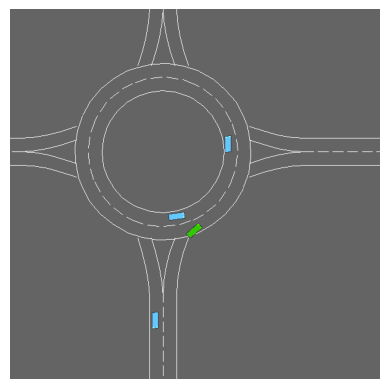

In [8]:
for _ in range(3):
    action = env.unwrapped.action_type.actions_indexes["IDLE"]
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render()) # draw the current scenario
plt.axis('off')
plt.show()

Key aspects of ``ep_len_mean`` and ``ep_rew_mean`` can be seen on tensorboard. But, to also notice loss, we need a separate callback

In [9]:
# Custom callback to log loss
class LossCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(LossCallback, self).__init__(verbose)
        self.losses = []

    def _on_step(self):
        # Log loss after each update
        if "train/loss" in self.logger.name_to_value:
            loss = self.logger.name_to_value["train/loss"]
            self.losses.append(loss)
        return True

loss_callback = LossCallback()

In [10]:
#%tensorboard --logdir "highway_dqn"

In [11]:
model = DQN('MlpPolicy', env,
                policy_kwargs=dict(net_arch=[256, 256]),
                learning_rate=25e-5,
                buffer_size=20000,
                learning_starts=1000,
                batch_size=32,
                gamma=0.9,
                train_freq=1,
                gradient_steps=1,
                target_update_interval=50,
                exploration_fraction=0.6,
                verbose=0,
                tensorboard_log='highway_dqn/')

In [12]:
start = time.perf_counter()
model.learn(total_timesteps=20000, callback=loss_callback)
end = time.perf_counter()

s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Time to run: {s2mps(end - start)}")

Time to run: 20 min 13.59 s


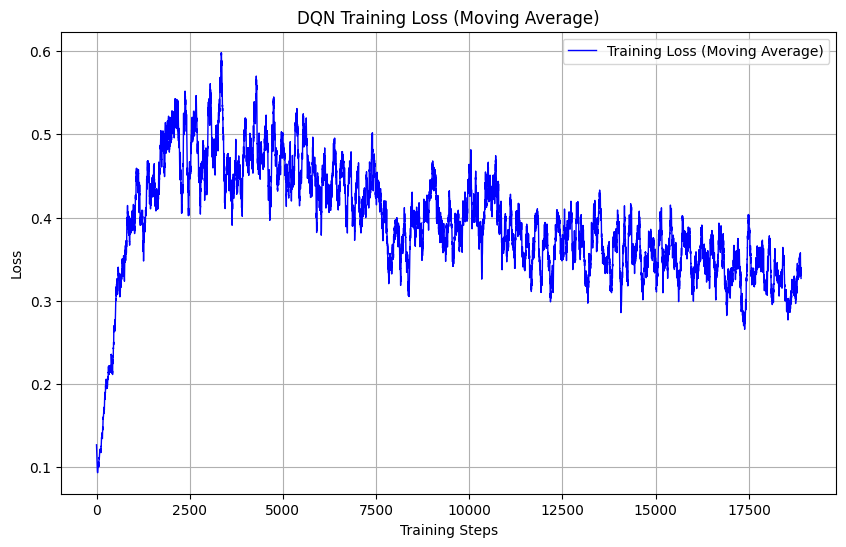

In [13]:
# Computing the moving average of the loss
window_size = 100
moving_avg = np.convolve(loss_callback.losses, np.ones(window_size)/window_size, mode='valid')

# Plotting the moving average of loss
plt.figure(figsize=(10, 6))
plt.plot(moving_avg, label='Training Loss (Moving Average)', color='blue', linewidth=1)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('DQN Training Loss (Moving Average)')
plt.legend()
plt.grid()
plt.show()

In [14]:
# Here we look an N=25 episodes and calculate time to fail and distance traveled to fail
n_tests = 25

# Initialize lists to store results for each episode
total_failtime = []
total_distance = []
total_reward = []

# Define the simulation frequency (steps per second), FIX: should be extracted from env_config
simulation_frequency = 15

for ix in range(n_tests):
    timetofail = 0
    distance = 0
    sumreward = 0
    done = truncated = False

    obs, info = env.reset()
    # Run the episode until termination (either done or truncated)
    while not (done or truncated):

        # Use the trained model to predict the next action deterministically and executing the action in env
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)

        timetofail += 1
        sumreward += reward
        distance += info['speed'] / simulation_frequency

    # Append the results of this episode to the respective lists
    total_failtime.append(timetofail)
    total_distance.append(distance)
    total_reward.append(sumreward)

# Calculate and print the average results across all test episodes
print(f'Avg time to fail [s] = {np.sum(total_failtime) / n_tests / simulation_frequency:.2f}')
print(f'Avg distance traveled [m]= {np.sum(total_distance) / n_tests:.2f}')
print(f'Avg reward = {np.sum(total_reward) / n_tests:.2f}')

Avg time to fail [s] = 0.65
Avg distance traveled [m]= 8.64
Avg reward = 9.09


__Reward Function:__

``lane_change_reward`` at $-0.1$ seems appropriate. Experiment with others

tested with DQN following key parameters:
```
learning_rate=5e-4,
buffer_size=20000,
learning_starts=1000,
batch_size=32,
gamma=0.9,
train_freq=1,
gradient_steps=1,
target_update_interval=50,
exploration_fraction=0.6,
```

| Ex. No. |collision_rew |high_speed_rew |right_lane_rew|Avg Time |Avg Distance | Avg Reward|
|----|----|----|----|---|---|---|
|1|-2 | 0.5 | 0.3 | 0.6|6.90|8.18|
|2|-2|0.6|0.3|0.62|7.22|8.30|
|3|-2|0.6|0.2|0.66|7.33|8.99|

           

As, ``ep_len_mean`` and ``ep_rew_mean`` more or less continously increase, while loss continuously degrade, using 20,000 timesteps should be considered appropriate.

Also, as `high_speed_reward` at $0.6$ and `right_lange_reward` at $0.2$ gave best results. We will persist with it, and next, experiment with `learning_rate` and discount `gamma`

|Ex. No.|learning_rate|gamma|Avg Time|Avg Distance | Avg Reward|
|---|----|--|---|--|--|
|1|5e-4 | 0.9 |0.66 | 7.33 | 8.99|
|2|25e-5 | 0.9 |0.66 | 7.22| 8.90|
|3|5e-4 | 0.95|0.70|4.31|8.86|
|4|25e-5|0.95|0.72|4.56|9.19|

Will stick with ``gamma`` at $0.9$ and ``learning_rate`` at $25e-5$, and run ``record_video`` as well beneath.

In [ ]:
if True:
    env = env_create()
    env = record_videos(env)

    # Loop through a specified number of test episodes to evaluate the model
    for episode in trange(2, desc='Test episodes'):
        (obs, info), done = env.reset(), False
        while not done:
            # Use the trained model to predict the next action deterministically
            action, _ = model.predict(obs, deterministic=True)

            # Take the predicted action in the environment and observe the results
            obs, reward, done, truncated, info = env.step(int(action))

    env.close()
    show_videos()

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test episodes:   0%|          | 0/2 [00:00<?, ?it/s]